# Abstract
Causal inference under Pearl’s framework of structural causal models has been the subject of intense theoretical study, but performant open-source implementations of many of the key algorithms are still lacking or, where they exist, are not widely adopted or maintained. I present `pqp` (short for *Pourquoi-pas?*), a end-to-end library for structural causal inference that includes an implementation of Shpitser’s IDC algorithm for identification of conditional causal effects in semi-Markovian causal models as well as tools for estimation. The library includes sophisticated memory-sharing graph data structures, a symbolic simplification routine, and it comes wrapped in an elegant Python interface. FInally, I have created a number of educational resources to help users get started with the library.

# Executive Summary

Causal inference is a fundamental task in many fields, including epidemiology, economics, and data science. One popular framework for causal inference is Pearl's structural causal modeling framework, which utilizes directed acyclic graphs (DAGs) and the do-calculus to explicitly model potential causal relationships. (Pearl, 2000) This approach allows for a clear and intuitive representation of causal assumptions, while also helping to avoid common biases that can arise with other methodologies. However, a crucial step in this framework is identification: translating a causal question into an abstract statistical estimator that can be estimated using a combination of a model and parametric assumptions.

One important algorithm for identification in the structural causal modeling framework is Shpitser's algorithm for conditional interventional effects. (Shpitser, 2008) This algorithm is polynomial time and guarantees a result when one is possible. However, existing open-source implementations of this algorithm are often incorrect, slow, or unmaintained. In this paper, I present a novel implementation of Shpitser's algorithm, written in Rust for efficient cross-functional use. Our implementation is production-quality code and includes extensive testing routines to ensure performance and correctness.

To bridge the gap between theoretical algorithm and practical tool, I developed two techniques as subroutines to the algorithm. I developed and implemented a heuristic symbolic simplification algorithm. To protect the speed and memory efficiency of the program, I designed a memory-sharing graph datastructure which allows similar graphs to share memory via a system of references and immutable data. Further, I am close to finishing an implementation of a estimation technique which will extend the work in Brule (2018).

To aid in adoption of this algorithm, I designed and implemented a user-friendly Python wrapper. This wrapper allows for the specification and visualization of causal graphs using a concise and elegant API, as well as giving the user full access to the underlying algorithms. In addition, this wrapper tracks steps in a user's analysis, constructing a computational graph of intermediate results. This graph tracks assumptions made by the various subroutines of the algorithm, allowing the user to access a list of the assumptions made during an analysis so they can understand potential limitations. The wrapper is available as a Python package on PyPi, and I created a website with documentation.

I created a number of educational resources to share my work: a Medium article detailed some of the theoretical background and two explainer videos covering practical use of the library.

# Overview

The paper is organized as follows: in the first section, I provide an overview of much of the literature on structural causal modeling. I review the literature on available implementations of the algorithm and justify the need for this implementation.

In the Implementation section, I describe technical insights I employed and analysis I performed on my implementation. I detail techniques I developed for simplication and memory-sharing, and I describe the extensive testing procedures I used to ensure correctness. I describe the Python wrapper I developed to make the algorithm accessible to a wider audience. I outline my technique for tracking assumptions made during analysis. I evaluate my implementation on correctness, performance, and ease of use.

Following the implementation, I provide an end-to-end example of using the library to estimate an effect. Then, I overview the educational resources I created as part of the project.

Appendices include HC/LO footnotes, documentation, and code.

## Contributions

In this work, I present a novel implementation of Shpitser's ID algorithm, including a comprehensive set of graph routines and a heuristic-based simplification algorithm. The implementation is written in Rust and the code is provided in the appendix. Additionally, I have developed Python bindings to facilitate usage of the algorithm. These bindings track assumptions made during the analysis in a computational graph that allows users to track the dependencies between various intermediate results and the assumptions they rely on.

In order to share my work with the broader community, I developed a high quality project website with detailed documentation. I wrote a Medium article which overviews some of the theory and introduces the library. I also created two explainer videos which provide a practical intro to using the library.

It is important to note that while this implementation and techniques for simplification and memory-sharing are novel, the underlying algorithm and all the material covered in the Background section is not a contribution of this paper and is instead a summary of the current state of the field.

## Links

- Documentation: [https://leo-ware.github.io/pqp/index.html](https://leo-ware.github.io/pqp/index.html)
- Source code: [https://github.com/leo-ware/pqp](https://github.com/leo-ware/pqp)
- PyPI Distribution: [https://pypi.org/project/pqp/](https://pypi.org/project/pqp/)
- Medium Article: [https://medium.com/@leoware/causal-inference-a-four-stage-framework-7fc2f8deafe2](https://medium.com/@leoware/causal-inference-a-four-stage-framework-7fc2f8deafe2)
- Video 1: [https://www.loom.com/share/91dc669b931d487a84c8030c80d2391c](https://www.loom.com/share/91dc669b931d487a84c8030c80d2391c)
- Video 2: [https://www.loom.com/share/7d8feab2b4f54a7caa59c495a9ce9858](https://www.loom.com/share/7d8feab2b4f54a7caa59c495a9ce9858)

## Note

AI text generation algorithms were used in the production of this text. Specifically, the OpenAI model ChatPGT was used extensively to edit for tone and concision.

# Background

## Structural Causal Models

### Overview

Structural Causal Models (SCM) provide a framework for modeling the generating process of a distribution. A structural causal model has four components: a set of observed variables $\textbf{V} = {v_1, v_2, ..., v_n}$, a set of unobserved variables $\textbf{U} = {u_1, u_2, ..., u_m}$, a distribution $P(U)$ over unobserved variables, and a set of functions $\textbf{F} = {f_1, f_2...f_n}$ such that each $f_i$ is a function from a subset of $\textbf{U} \cup \textbf{V} \backslash V_i$ to $v_i$. The arguments to $f_i$ are called the parents of $v_i$ or $pa(v_i)$ and they uniquely determine the value of $v_i$. Together, $P(\textbf{U})$ and $\textbf{F}$ induce $P(\textbf{V})$, a distribution over $\textbf{V}$.

We represent the causal assumptions in an SCM via a causal diagram. This is a directed acyclic graph (DAG) where each node corresponds to a variable in the model. A directed edge from $x_i$ to $x_j$ indicates that the value of $x_j$ depends on the value of $x_i$, or $x_i \in pa(x_j)$. To ensure the validity of an SCM, we restrict the set of valid models to those that can be represented by acyclic graphs, to prevent circular definitions between variables [1]. Algebraically, we can interpret a causal diagram as defining a set of conditional independence assumptions. In particular, as the parents of $v_i$ completely determine its value, $v_i$ will be independent of every other variable in the model, conditional on its parents.

Note the acyclicity assumption does not restrict the class of distributions that can be represented by an SCM because by the definition of joint probability any joint distribution $P(x_1, x2…x_n)$ can be factorized as $P(x_1 | x_2…x_n)P(x_2 | x_3…x_n)...P(x_n-1 | x_n) P(x_n)$. But, this can be represented as an SCM where $pa(x_i) = \{x_{i+1}, x_{i+2}…x_n\}$ without violating the acyclicity assumption. However, the any given causal graph may be consistent with only a subset of all possible distributions over the variables in the graph.

For the purposes of this paper, we make the additional assumption that each unobserved variable is the parent of at most two observed variables. This simplifies the graphical representation by replacing each unobserved variable and its outgoing edges with a single undirected edge connecting its two children. This can be interpreted as representing potential confounding between the two variables. An example of such a simplified graph is shown in Figure 1.

**Figure 1. Using Bidirected Edges to Represent Confounding**
![](2023-01-14-13-06-10.png)
*This figure shows an unobserved variable $C$ with two children being replaced with a bidirected, dashed edge. The bidirected edge represents the same information as $C$ did in the first diagram, but it is only possible to represent confounders with bidirected edges if they have exactly two children.*

### Conditional Independence Properties of Causal Diagrams

One of the key properties of causal diagrams is that they can provide insight into the conditional independence properties of a distribution $P(\textbf{U} \cup \textbf{V})$. As previously discussed, a variable $v_i$ is independent of all other variables in the model, conditional on its parents. This concept of a "flow of dependence" along edges connecting a node to its parent is a useful tool for understanding the conditional independence assumptions encoded in a causal diagram.

However, it is important to note that dependence does not flow along every path in the diagram. Paths can be blocked by conditioning on certain variables, which alters the conditional independence properties of the distribution. We can view a path as a collection of vertices, each of which must have one of the following forms:

$$X \leftarrow Y \leftarrow Z$$
$$X \rightarrow Y \rightarrow Z$$
$$X \leftarrow Y \rightarrow Z$$
$$X \rightarrow Y \leftarrow Z$$

In the first three cases, dependence will flow through the vertex as long as we do not condition on $Y$. In this case, we call the vertex unblocked. Conditioning on $Y$ blocks the path and prevents dependence from traveling along it. This means that, as long as this is the only path connecting $X$ and $Y$, the causal diagram is predicting that $X$ and $Z$ will be independent conditional on $Y$.

The third case, known as a collider, is slightly different. The last vertex will be unblocked if and only if we condition on $Y$.

To illustrate the concept of colliders, consider the example of college admissions. Without knowledge of whether a student was admitted, learning her SAT scores tells us nothing about her admissions essays. However, if we know that the student was admitted, and we observe that her SAT scores were low, we can infer that her essays must have been good.

A path is considered blocked if any vertex along it is blocked. If, after conditioning on a set of variables $\textbf{Z}$, there are no unblocked paths connecting two variables $v_i$ and $v_j$, then the model predicts that $v_i$ and $v_j$ are independent conditional on $\textbf{Z}$. In this case, we say that $v_i$ and $v_j$ are d-separated by $\textbf{Z}$. This concept of d-separation provides a means to connect the ideas of statistical association in the joint distribution with properties of the graph, and allows us to use graphical models of causal relationships to make testable predictions about datasets.

**Figure 2. Examples of D-Separation**

![](2023-01-14-13-52-24.png)

*The figure shows an example of a causal graphical model. Nodes represent random variables, and edges represent direct causal influence.*

For example, in figure 2 we can make the following predictions about distribution $P(\textbf{V})$ based on the causal diagram:

- $A \perp\!\!\!\!\perp C$ but not $A \perp\!\!\!\!\perp C | D$
- $A \perp\!\!\!\!\perp B | C$ but not $A \perp\!\!\!\!\perp B | C, D$
- $B \perp\!\!\!\!\perp D | C$ but not $B \perp\!\!\!\!\perp D$

### Graph Surgery and Causal Effects

In causal inference, a fundamental task is to measure the causal effect of one set of variables, $X$, on another, $Y$. To operationalize this task within the Structural Causal Model (SCM) framework, we utilize the concept of interventions. Specifically, in the SCM, the values of $X$ are determined by its parents, $pa(X)$. However, we are interested in understanding the effect of altering the value of $X$ through intervention, rather than allowing it to be set by its natural causes. To model this intervention process, we perform "graph surgery" by cutting all incoming edges into $X$, and examining the resulting interventional distribution. This allows us to isolate any remaining conditional effect of $X$ on $Y$, which can then be interpreted as a causal effect.

To gain further insight into this process, we can consider two types of paths that may connect $X$ and $Y$: backdoor paths and frontdoor paths. Backdoor paths are those that connect to $X$ through its parents, while frontdoor paths connect through its children. These paths represent different mechanisms through which $X$ may affect $Y$; frontdoor paths indicate direct causal effects, while backdoor paths indicate indirect effects through other variables (i.e. confounding). By performing graph surgery and cutting all backdoor paths, we effectively isolate any causal effects flowing through frontdoor paths.


### The Do-Calculus

In the Structural Causal Model (SCM) framework, causal queries are represented by the use of the "do-operator." The do-operator is indicated by its placement behind the conditioning bar in a probability expression, and it represents a modification of the underlying generating process. To illustrate, for sets of variables $X$, $Y$, and $Z$, the expression $P(Y | do(X), Z)$ represents the conditional probability $P(Y | X, Z)$ in the model that results from performing graph surgery on $X$. This represents a hypothetical scenario in which $X$ is fixed through intervention, rather than being determined by "nature." A "do-expression" is any probability expression containing the do-operator.

Both the average treatment effect (ATE) and the conditional average treatment effect (CATE) can be expressed in terms of do-expressions. The ATE is given by:

$ATE = E(P(y | do(x = 1))) - E(P(y | do(x = 0)))$

while the CATE is given by:

$CATE = E(P(y | z, do(x = 1))) - E(P(y | z, do(x = 0)))$

The manipulation of do-expressions is facilitated by Pearl's "do-calculus", which references properties of the model in which the do-expression is evaluated. The do-calculus provides conditions under which do-operators can be removed from an expression or replaced with conditioning. This is advantageous because it allows us to transform do-expressions, which cannot be estimated from the data, into traditional statistical estimands (e.g., $P(Y | X, Z)$), which can be estimated using parametric assumptions.

$
\textbf{Rule 1 } \text{Insertion/deletion of observations:}\\
P(Y | do(X), Z, W) = P(Y | do(X), W) \\
\text{if } (Y \perp\!\!\!\!\perp Z | X, W)_{G_{\overline{X}}}
$

$
\textbf{Rule 2 } \text{Action/observation interchange:}\\
P(Y | do(X), do(Z), W) = P(Y | do(X), Z, W) \\
\text{if } (Y \perp\!\!\!\!\perp Z | X, W)_{G_{\overline{X} \underline{Z}}}
$

$
\textbf{Rule 3 } \text{Insertion/deletion of actions:}\\
P(Y | do(X), do(Z), W) = P(Y | do(X), W) \\
\text{if } (Y \perp\!\!\!\!\perp Z | X, W)_{G_{\overline{X} \overline{Z(W)}}}
$

The task of removing the do-operators from a do-expression and turning it into a statistical estimand is called "identification." It is a crucial step in the process of causal inference in the SCM framework. General procedures for identification allow us to express causal queries in the rich language of do-expressions and then algorithmically translate these queries into statistical estimands that can be directly estimated from the data. Additionally, because identification does not make any parametric assumptions about the data, it allows us to decouple our causal assumptions from our parametric assumptions during modeling.

### The Four Stages of Causal Inference

Structured causal effect estimation is a four-step process consisting of modeling, identification, estimation, and robustness checks.

1. Modeling: This step involves identifying plausible causal relationships in the form of a directed acyclic graph (DAG). The DAG serves as a representation of the causal structure of the system being studied.

2. Identification: Once the causal structure is represented in the form of a DAG, the next step is to translate a causal query into an abstract estimator in the context of these assumptions. This process is known as identification, and it is a crucial step in the process of causal inference.

3. Estimation: After the abstract estimator has been derived, the next step is to add parametric assumptions and pick a specific model to represent the abstract estimator. This model is then fitted to the data, and an estimate of the causal effect is extracted.

4. Robustness checks: The final step is to assess the robustness of the analysis to the specifics of the assumptions made in the modeling process. This is done by perturbing the assumptions of the modeling process and determining the sensitivity of the analysis to these perturbations. These robustness checks are important for ensuring the validity and generalizability of the causal estimates.

It's important to note that the modeling, identification, estimation and robustness checks are interrelated, and that making progress in one step may require revisiting the others.

## The Problem of Identification

### Overview

It is important to note that not every causal estimand can be unambiguously estimated in every model. Identification, or the process of determining the causal estimand from the joint distribution, may fail when it is impossible to unambiguously determine $P(Y | do(X))$ from $P$. Identification is always possible in a graph with no confounding, but in some cases it is not possible because it is not possible to disentangle the effect from possible confounding. For example, in a model with a bidirected edge between variables, it may be impossible to identify $P(Y | do(X))$ because any observed effect could be explained by confounding along the bidirected edge, and there is no way to control for this.

**Figure 4. The Bow Graph**

![](2023-01-14-14-22-06.png)

*The bow graph is the simplest example of a graph with a non-identifiable interventional distribution.*

The rules of the do-calculus provide complete conditions for identification of causal estimands; if it is possible to convert the causal estimand to a statistical estimand, then it is possible using the do-calculus. However, manually applying the rules of the do-calculus to derive an abstract estimator is time-consuming and requires the researcher to make reference to complex properties of the causal graph, which is a task humans are ill-suited to, especially as the complexity of the graph grows. In the general case, it is too complex a task to be performed by hand.

Thus, it is necessary to find algorithms by which identification can be performed automatically. This is a nontrivial problem; naive approaches often have exponential time complexity in the size of the graph, and the best algorithms, while polynomial time, rest on complex graph theory.

Some researchers have simplified this problem by sidestepping direct application of the do-calculus and instead using the concept of adjustment sets. These methods rely on finding a set of variables which, when controlled for, block all backdoor-paths from the intervention set to the outcome set. However, these approaches face two distinct challenges. First, naive approaches to adjustment set search, such as those implemented in Knupple (2010), Breitling (2010), and Sharma (2020) rely on enumerating the set of all possible adjustment sets and then checking whether each successfully blocks all backdoor paths. This is an issue because the number of possible adjustment sets grows exponentially in the number of nodes in the graph. This makes these approaches infeasible for even fairly small graphs.

More efficient algorithms exist for adjustment set search, such as the one proposed in Textor and Liskiewicz (2011), which works in polynomial time. However, the drawback of these algorithms is that although every valid adjustment set corresponds to a valid statistical estimator for the query, not every valid statistical estimator can be represented as an adjustment set. Because these algorithms are only searching among adjustment sets, they fail in cases where other classes of estimator are needed.

To illustrate, in the famous front-door model, the interventional distribution $P(Y | do(X))$ is identified by the simple statistical estimator $P(Y | do(X)) = \sum_z P(Z | X) \sum_x P(Y | Z, X) P(X)$. This estimator works by breaking the problem into two subproblems: first identifying the interventional distributions $P(M | do(X))$ and $P(Y | do(M))$ and then combining these to identify $P(Y | do(X))$. Each subproblem can be solved using an adjustment set operator, but there is no adjustment set estimator which identifies $P(Y | do(X))$.

### C-components

Front-door estimation is an interesting technique, but it also illustrates a larger concept in causal inference known as c-component factorization. C-components, or connected components, are subsets of the graph that are connected via bidirectional (confounding) edges. Two nodes, $A$ and $B$, in a causal graph are in the same c-component if and only if there is a path from $A$ to $B$ that only follows bidirectional edges. It has been shown that any causal graph can be uniquely partitioned into a minimal set of c-components (Tian, 2002).

More importantly, Tian (2002) showed that for any c-component $C$ in a graph $G$, the interventional distribution $P(C | do(V \backslash C))$ is identifiable, where $V$ denotes the set of nodes in $G$ and $\backslash$ represents set difference. This means that the problem of identifying $P(Y | do(X))$ can be broken down into a set of subproblems, one for each c-component in the graph $G \backslash X$. This is the first critical insight that enables efficient identification and is known as c-component factorization.

C-components also allow for the introduction of more complex graphical structures, such as the c-tree. A $Y$-rooted c-tree is a graph $G$ that contains both directed and bidirected edges, where the entire graph is a single c-component and every node has at most one child. Additionally, there is a single node $Y$ that has no children. If there are multiple nodes with no children, these nodes are referred to as the root-set of $G$, and the graph is called a c-forest.

**Figure 4. A C-Tree and  C-Forest**

![](2023-01-14-15-01-52.png)

*This figure shows a c-tree (left) and a c-forest (right). Note that both are c-components because they are completely connected by bidirectional edges. In addition, in both, no node has more than one child. However, in the c-tree, C is the only node without children. This makes this a $C$-rooted c-tree. On the other hand, the graph on the right has two nodes without children: $C$ and $G$. This makes it a $\{C, G\}$-rooted c-forest.*

By utilizing c-forests, the concept of a hedge can be defined. Hedges are graphical structures that prevent the identification of interventional distributions. In a causal graphical model with graph $G$, if an interventional distribution $P(Y | do(X))$ is sought for two sets of random variables $X$ and $Y$, and if there exist two subgraphs $F$ and $F'$ such that the intersection of $F$ and $X$ is non-empty, but the intersection of $F'$ and $X$ is empty, and if $F'$ is a subgraph of $F$, and both form $Z$-rooted c-forests, where $Z$ is a subset of $Y$, the interventional distribution $P(Y | do(X))$ will be identifiable if and only if such $F$, $F'$, and $Z$ do not exist.

In other words, if two nested c-forests are found, where at least some elements from $Y$ are in their root set, and the smaller one does not contain any elements from $X$ but the bigger one does, the interventional distribution is not identifiable.

### Shpitser's Algorithm

Shpitser’s ID algorithm exploits the properties of c-components to identify interventional distributions. It is polynomial time and can always derive an estimator if one exists. The algorithm works as follows (Shpitser, 2008):

$
\text{function }\textbf{ID}(y, x, P, G)\\
\text{INPUT: x, y value assignments, P a probability distribution, G a causal diagram}\\
\text{OUTPUT: Expression for } P_x(y) \text{in terms of } P \text{ or } \textbf{FAIL}
$

$
\text{1. if } x = \emptyset \text{ return } \sum_{v \setminus y} P(v)\\ \\
$

$
\text{2. if } V \setminus An(Y)_G \ne \emptyset \\ \text{ return } \textbf{ID}(y, x \cap An(Y)_G, \sum_{v \setminus An(Y)_G} P, G_{An(Y)})
$

$
\text{3. let } W = (V \setminus X) \setminus An(Y)_{G_{\overline{x}}} \\
\text{if } W \ne \emptyset \text{, return } \textbf{ID}(y, x\cup w, P, G)
$

$
\text{4. if } C(G \setminus X) = {S_1...S_k}\\
\text{return } \sum_{v \setminus (y \cup x)} \prod_{i} \textbf{ID}(s_i, v \setminus s_i, P, G)
$

If line 4 does not return, then $C(G \setminus X) = {S}$

$
\text{5. if } C(G) = {G} \text{, throw } \textbf{FAIL}
$

$
\text{6. } S \isin C(G) \text{ return } \sum_{s \setminus y}\prod_{ \{i | V_i \subset S \} } P(v_i | v_\pi^{(i - 1)})
$

$
\text{7. if } (\exists S') S \subset S' \in C(G) \\
\text{ return } \textbf{ID}(y, x \cap S', \prod_{ \{i | V_i \subset S' \} }P(V_i | V_\pi^{(i - 1)} \cap S', v_\pi^{(i - 1)} \setminus S'), G_{S'})
$

The first three lines set up the algorithm. Line one is a base-case for identifiability. Lines two and three perform simplification.

Line four works by breaking up the identification problem into subproblems. Considering the subgraph $G’ = G \setminus X$, we find the c-components $\{s_i\}$ of $G’$. If there is more than one, then we can identify $P(Y | do(X))$ by finding the interventional distribution $P(s_i | do(G \ s_i))$ for each $s_i$. Because of c-component factorization, we know that all such terms will be identifiable if and only if $P(Y | do(X))$ is identifiable. We can then take the product of all such terms to get a joint interventional distribution over the nodes in $G’$. By marginalizing all variables other than those in $X$ and $Y$, we can identify the interventional distribution.
 
After repeated application of the above step, we will be in a position where $G’$ consists of a single c-component. There are three possible ways in which $X$ could relate to $G’$. $X$ and $G’$ could together form a single c-component. In this case, we have discovered a hedge, proving the interventional distribution is not identifiable (line 5). There could be no bidirectional edges connecting elements of $G’$ to elements of $X$. In this case, there are no backdoor paths from $X$ to $G’$ and we can identify the interventional distribution by conditioning on $X$ (line 6). It could be that some elements $Z \subset X$ are connected via bidirectional edges to elements in $G’$, while others $W \subset X$ are not. In this case, we can condition on $W$ and make a recursive call to the algorithm, attempting to identify the interventional distribution $P(G’ | do(Z))$ (line 7).
 
The algorithm as described so far can only deal with queries of the form $P(Y | do(X))$, but often we will wish to calculate conditional interventional effects of the form $P(Y | do(X), Z)$. Thankfully, queries of this form can be mapped to queries without a conditional term with only a minimal transformation. This modification of the algorithm is known as IDC, or ID with conditioning, and it eliminates conditional variables in two ways. The first way is using Rule 22 of the do-calculus: if a conditional variable $z \in Z$ has no back door paths to $Y$ when conditioning on $X$ and $Z \ z$, then conditioning on z is equivalent to intervening on it, and it can be put inside the do operator. The second way is to treat $z$ as an outcome, run the algorithm, and then condition on $z$. Together, these two techniques can be used to eliminate all conditional variables from the query.

## Pre-existing Implementations

A number of open source implementations of the ID algorithm existed prior to my work. Dowhy is a popular python library developed by Microsoft Research, but its implementation is too slow. Researchers working on the dowhy project explicitly asked me to create a faster implementation and integrate it with their library. There is also an implementation in Clojure called Whittemore which is quite fast, but because Clojure is a JVM language it is not possible to integrate this implementation with Python, R, or Javascript code. I based my implementation on Whittemore. Ananke is a causal inference library developed by Shpitser’s team, and it has an implementation of a related algorithm, but Ananke has not seen widespread adoption, and it is unmaintained. FInally, the Javascript/R tool Daggity has an implementation of adjustment set operators, which suffer from the drawbacks discussed above.

# Implementation

## Technical Challenges

### Graph Representation and Subroutines
As a prerequisite to the rest of the work I did for this project, I implemented a set of graph routines to capture key operations that need to be performed during the algorithm. The key operations here are c-component factorization and ancestor search. C-component factorization is breaking partitioning the graph $G$ into subgraphs $S_i$ that obey the following constraints. Any two nodes ${a, b} \subset S_i$ there exists a path from $a$ to $b$ along bidirectional edges, and for any two nodes $c \in S_i$ and $d \in S_j$ if $i \ne j$ then there does not exist such a path. Ancestor search is the problem of finding the set $An(y)$ for a nodes $y$ such that a node $w$ is a member of $An(y)$ if and only if there is a directed path from $w$ to $y$.

Because of of these operations only requires access to one kind of edge (directed or bidirected), I model a causal graphical model as consisting of two graphs: one directional and one bidirectional. The directional graph data structure handles ancestor queries, and the bidirectional graph data structure handles c-component factorization. Each of these problems is trivially solvable in $O(E)$ (order of number of edges in the graph) using breadth-first search. The subtlety here is because of the way the algorithm recursively parititons the graph into subproblems, we will be repeatedly rerunning ancestor and c-components queries on slightly modified versions of the graph. The causal graph data structure needs to efficiently handle arbitrary series of the following four operations:

- c-component queries
- ancestor queries
- graph surgery (maintaining a copy of the original graph)
- node deleletion (maintaining a copy of the original graph)

Specifically, lines 2 and 3 of the algorithm require ancestor queries, and in the case of line 3, this query is performed after surgey. Lines 4 and 5 require c-component queries, and line 4 requires first removing $x$ from $G$.

Since a structure representing the original graph must be maintained through deletions, we cannot just apply these as mutable changes to the data structure. So, a naive approach would be to make a copy of the graph at each modification and run the queries on this copied graph. This is quite wasteful from a resource standpoint though because it requires a linear-time $O(N + E)$ copy operation (order of number of nodes plus number of edges) at each modification. Since the algorithm has a worst case recursion-depth of $O(N)$, this amounts to an an additional quadratic order $O(N^2 + NE)$ runtime cost. The more concerning term here is the $NE$, because number of edges can grow with $O(N^2)$, so this term could be cubic. Although this is unlikely to be an issue in manually-specified models, it could become a real problem is models derived via automated causal discovery (e.g. in geothermal or econometric datasets) or in bioinfomatics applications, where causal networks are used to study genetic data, and models can get quite complicated.

To address this problem, I implemented a set of routines that allows small modifications to be performed to the original graphs in such a way that a new data structure is created which is logically distinct inside the program but which uses most of the same memory. This reduces the memory footprint of the algorithm as well as reducing time spent copying data.

Instead of copying the causal graph when subgraphing, the data structure maintains a reference to the original graph, and each subgraph tracks the nodes which it currently contains and the nodes which have been the subject of surgery. It is still possible to perform c-component and ancestors queries with the same time complexity. This requires a $O(N)$ operation, but it avoids the especially costly $O(NE)$ term in the final time complexity.

### Simplification
Simplification is an important step in computational identification because the ID algorithm tends to return symbolic expressions that are quite complex and require simplification. The complexity of these outputs is not indicative of the complexity of the "answer", but they tend to contain many elements which are algebraically redundant. E.g., frequently identical terms will appear in the numerator and denominator of a quotient. A few lines of mathematical manipulation can reduce the complexity of these expressions significantly, but it is a nontrivial problem to write a program that can do this.

It is important to simplify the results for a couple of reasons. Simpler expressions are easier for humans to understand. They make it easier to test the program because they reduce the number of “correct” answers to an identification problem. And, maybe most importantly, simpler expressions are easier to evaluate numerically. It is both computationally cheaper and more accurate to simplify an expression before applying numerical estimation techniques.

Whittemore, which I have borrowed from extensively, uses a heuristic-based simplification algorithm with just a couple of rules. My original plan was to just use this, but their algorithm contains idiosyncracies that I think may indicate a mathematical error. I plan to present an example failure case in the next iteration of this report.

Tikka and Karvanen (2017) describe a simplification routine that uses properties of the graphical model to find ways to reduce conditional terms. I was originally optimistic about this approach as it has nice guarantees on the degree of simplification. However, this approach has a time complexity that gorws significantly faster than exponential in the number of variables, and so would not prove practical for real problems.

Instead of relying on these solutions, I developed my own heuritsitc simplification algorithm. This algorithm relis on an observation that most of the redundancy in the estimands generated by the algorithm can be remedied by fairly simple algebra. I implemented a simple recursive algorithm that applies a series of transformations on elements in the symbolic expression. It traverses the expression tree, replacing each node with a simplified version.

For each possible type of subexpression, the following transformations are applied:

expression type | transformations | example | example (simplified)
---|---|---|---
Quotient | Merge nested quotients and products. Cancel identical terms. | ${P(a)(P(b)P(c)) \over {P(b) \over P(d))}}$ | $P(a)P(c)P(d)$
Product | Merge nested products and quotients. | ${P(a) \over P(b)} P(c)$ | $P(a)P(c) \over P(b)$
Marginal | Convert sum over joint distribution to marginal distribution. | $\sum_{a} P(a,b)$ | $P(b)$
Conditional Probability | Convert to quotient. | $P(a \| b)$ | ${P(a, b) \over P(b)}$

This scheme has the disadvantage that no conditional probability expressions are left in the final result, which can make the formulas less readable. But, this is worth it because in quotient form it is much easier to identify redundant terms and cancel them. So, the formulas end up simpler on balance.

To demonstrate the effectiveness of this technique, I apply this algorithm to the front door estimator. This expression is unsimplified expression, and it represents the form of the expression that is derived using ID. 

$$
P(y | do(x)) = \sum_{Z} \big(\sum_{} \big(\sum_{X} \big({\sum_{} \big(P(X, Z, Y)\big) \over \sum_{Y} \big(P(X, Z, Y)\big)} {\sum_{Z, Y} \big(P(X, Z, Y)\big) \over \sum_{Z, Y, X} \big(P(X, Z, Y)\big)}\big)\big) \sum_{} \big({\sum_{} \big(\sum_{Y} \big(P(X, Z, Y)\big)\big) \over \sum_{Z} \big(\sum_{Y} \big(P(X, Z, Y)\big)\big)}\big)\big)
$$

After simplification, the expression is reduced to the following form. This example highlights the need for a simplification algorithm, and it shows that the heuristic simplification algorithm is surprisingly effective for outputs of this size.

$$
P(y | do(x)) = \sum_{Z} \big({\sum_{X} \big({P(X) P(X, Z, Y) \over P(X, Z)}\big) P(X, Z) \over P(X)}\big)
$$

Both of the above expressions were generated by `pqp`.

A limitation of simplification is that, because it is implemented in Rust, it is only applied to the results of calls to the underlying Rust library, which is only for identifying specific interventional distributions. These expressions may be assembled into more complex estimands inside the Python library which cannot currently be simplified.

### Estimation

In order for the estimator to be useful, we need to be able to use it to actually estimate a treatment effect in the precense of real data and a set of parametric assumptions. I have implemented a feature that allows for parametric modeling and causal estimation on statistical quantities. This feature is implemented as part of the Python wrapper.

In general, estimation of useful quantities from identified estimands can be quite hard because they involve a large number of nested sums (or integrals, in the continuous case). The computational complexity of evaluating nested sums grows exponentially in the number of these sums, and there is no way to reduce this cost in the general case while still computing an exact value.

There are many approaches to this problem. A number of numerical approximation tools have been developed in the field of Bayesian statistics, but these a often quite finicky and most are heavy weight solutions. Shpitser (2012) shows how the conditional independence properties of causal graphs can be exploited to reduce the practical difficulty, but their algorithm is still exponential time. Bhattacharya et. al. (2021) used a variety of sampling techniques, but this is a heavyweight solution, and although the estimators they propose are doubly-robust, they still require fitting a number of intermediate linear models which carry undesirable parametric assumptions.

Due to the complex tradeoffs between algorithms and difficulty of implementation, I have chosen to extend Brule (2018) and implement a brute-force solution. Brule's estimator relies on directly calculating the sums, and as such remains completely non parametric and is tractable for small number of variables. Brule assumes that all variables in the model are discrete, which is needed for the brute-force approach, so to extend to the continuous case I plan to use quantization.

In addition to the computational difficulties, a further, slightly more subtle, difficulty has to do with the *positivity*. All useful estimators identified by ID will have conditional probability terms, and these remained defined only when the conditioning variable can be guaranteed to have positive probability in the model. Brule (2018) uses a maximum likelihood multinomial estimator, which does not guarantee positivity. To get around this issue, I use a Bayesian multinomial estimator with a Dirichlet prior, which does guarantee positivity.

### Interpretability

One problem with a large number of existing statistical software is that users often approach these tools with little udnerstanding of how they work or what exactly they are doing. This can lead to two main classes of issues: (1) users may not understand the assumptions that are being made by the software and thus fail to understand the limitation of an analysis, and (2) users may feel disempowered or "out of the loop". If the options are to either use a tool blindly or to dig into the source code or a dense textbook, then the former is often the more attractive option.

This is often okay in the context of predictive inference, as the goal is usually to simply make accurate predictions, and this can be checked against ground truth using a holdout set. But, in the context of causal inference, the goal is to make causal claims, and so there is no easily accessible ground truth against which to check the results. Additionally, many of the assumptions made in causal inference are often numerous and complex, and so users cannot be expected to know (or necessarily understand) them.

To approach these problem, I decided that it was important that users of `pqp` be able to access a summary of the intermediate steps, transformations, and underlying assumptions performed by the algorithms. As such, I implemented the Python wrapper to automatically construct a computational graph to track the dependencies between different intermediate results derived during an analysis. This allows the user to inspect the steps actually performed by the library during an analysis and understand the assumptions that are being made.

To achieve this technically, I implemented a `Result` class which stores the outputs of key computations, such as data preprocessing, model fitting, identification, and estimation. A higher order function (called `entrypoint` in the code) wraps the key subroutines which perform these calculations. When they are called, it dynamically captures inputs to these functions, saving them for reproducability or sensitivity analysis. It then searches the inputs for any instances of `Result` and, if found, adds these as dependencies of the current calculation. Then, it wraps the output of these functions in a `Result` which can access information about its logical dependencies. In addition, the subroutines report any transformations or assumptions they make, and these are captured by `entrypoint` and included in the metadata inside `Result`. As such, any `Result` object can be used to reconstruct the entire analysis up to that point, and it knows all the assumptions underlying it.

To use these in the code, you can call the `.explain()` and `.explain_all()` methods in the code to get an overall summary. A demonstration of this method is shown in the example below.

## Analysis

The primary goals for this implementation were correctness and ease of use. In this section, I examine the library in light of each of these goals.

### Correctness

One of the main impetus for this project was to improve on the many correctness issues with existing implementations of the algorithm. To this end, I implemented a large number of tests. I used hand derived answers to test the algorithm on a number of famous examples (backdoor, frontdoor, IV, bowgraph). Then, I copied all of the other examples of identification from Shpitser's dissertation (Shpitser, 2008). He gives 15 examples of identifiable and nonidentifiable graphs, and I test the algorithm the on each of these examples.

**Figure 5. Examples of identifiable graphs**

![](2023-02-25-09-07-36.png)

*This figure, taken from Shpitser (2008) shows several examples of identifiable graphs. My implementation recovers the correct estimator for each.*

To demonstrate typical output from the algorithm, I apply the algorithm to find estimators for each of these graphs. These estimators are shown below. The algorithm successfully recovers the estimator in each case. The only issue highlighted by this example is that the simplification routine still stuggles to achieve an acceptable outcome as graphs get larger. This is an area of active work.

In [1]:
from IPython.display import display, Math
from string import ascii_lowercase
from supplement import g1, g2, g3, g4, g5, g6, g7, x, y
from pqp.symbols import *

for i, g in enumerate([g1, g2, g3, g4, g5, g6, g7]):
    estimand = g.identify(P(y, given=do(x)))
    display(Math("\\textbf{Model " + ascii_lowercase[i] +
        ": } P(y | do(x)) = " + estimand.identified_estimand.to_latex()))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Similarly, Shpitser (2008) supplies of a number of examples of nonidentifiable graphs. The algorithm correctly identifies these as nonidentifiable. The examples from Shpitser (2008), along with estimators derived by the algorithm, are shown below.

**Figure 6. Examples of nonidentifiable graphs**

![](2023-02-25-09-22-50.png)

*This figure, taken from Shpitser (2008) shows several examples of nonidentifiable graphs. My implementation correctly identifies these as nonidentifiable.*

When run on each of these graphs, the algorithm successfully recovers a hedge, demonstrating non identifiability of each graph.

### Ease of Use
The Rust code underlying the library is extremely fast, but Rust is a language used by few in the causal inference community. To make the library more accessible, I created a Python library that wraps the Rust code. Although Python is definitely second to R in terms of adoption in the community, it is much more common among industrial practicioners.

While the focus of the Rust implementation is correctness and performance, the focus of the Python bindings is on elegance and usability. I used Python's magic methods to create an API for specifying and querying causal models that is extremely simple and readable. I created a website with documentation for the python library, and I have published the library on PyPI.

By utilizing Python's infix operators, I was able to create an API in which graphs can be created via an intuitive embedded syntax. It is possible to create a new causal model using the library in just a few lines. The `<=` operator creates a directed edge in the graph, while the `&` operator creates a bidirected edge. See the following example, which implements the front-door model.

In [2]:
from pqp.symbols import *
from pqp.identification import Graph

x, y, z = make_vars("xyz")
g = Graph([
    z <= x,
    y <= z,
    x & y
])

Identification of arbitrary estimands is accessed through the `.identify()` method of the `Graph` class. Causal estimands can be specified using a set of symbolic operators that provide a high degree of leverage in specifying the desired quantity.

In [3]:
# identification of interventional distribution
interventional = P(y, given=do(x))
g.identify(interventional).identified_estimand.display()

<IPython.core.display.Math object>

In [4]:
# identification of ATE
ate = Expectation(y, P(y, given=do(x.val == 1)) -
    P(y, given=do(x.val == 0)))
g.identify(ate).identified_estimand.display()

<IPython.core.display.Math object>

A number of convenience subroutines are also available for more complex common queries.

In [5]:
from pqp.identification import CATE

cate = CATE(
    outcome=y,
    treatment_condition={x: 1},
    control_condition={x: 0},
    subpopulation={z: 1}
)
g.identify(cate).identified_estimand.display()

<IPython.core.display.Math object>

The library also supports visualization using the `networkx` library as an optional dependency. Although this feature is not entirely polished yet, it is useful to quickly visualize the model. Bidirected edges are indicated using a dashed line. This feature is demonstrated in the examples section below.

# Example

In this section, I show how my code can be used to estimate an average treatment effect using the front door model on a simulated dataset. The dataset has four variables: $x$, $z$, $y$, and $m$. The variable $x$ represents a treatment which influences an outcome $y$ via a mediator $m$. The variable $z$ is a confounder which influences both $x$ and $y$. The following graph shows the causal structure of the model. All are binary except for $y$, which is on ${1, 2, 3}$.

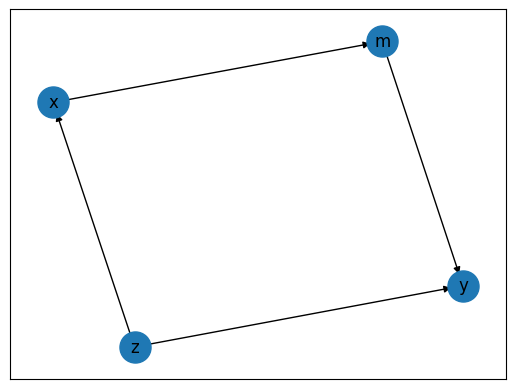

In [6]:
x, y, z, m = make_vars("xyzm")
g = Graph([
    x <= z,
    m <= x,
    y <= [m, z],
])
g.draw()

In the dataset, $x$ has the effect of raising the value of $y$ by $-0.5$ by virtue of the process which simulated the data. We can quickly recover this quantity using the graph above.

In [7]:
from pqp.estimation import MultinomialEstimator
from pqp.identification import ATE

df = pd.read_csv("demo1.csv")
model = MultinomialEstimator(df)
effect = ATE(y, x)

estimand = g.identify(effect)
model.estimate(estimand)

EstimationResult(value=-0.4732071277264369)

However, what if $z$ were unobserved, would we still be able to recover the result? We first attempt this without reference to our knowledge of the data generating process. This is equivalent to directly regressing $y$ on $x$ without any controls.

In [8]:
naive_graph = Graph([
    y <= x
])
naive_estimand = naive_graph.identify(effect)
model.estimate(naive_estimand)

EstimationResult(value=0.00768827677796402)

It turns out that in this dataset, the effect of $z$ is to exactly cancel out the effect of $x$ on $y$. So, we won't be able to estimate the effect directly. In addition, there is no sufficient adjustment set to recover the effect of $x$ on $y$. However, we can use ID to identify the estimand. Since we are taking $z$ as unobserved, we represent $x$ and $y$ as confounded in this model.

In [9]:
g = Graph([
    m <= x,
    y <= m,
    x & y
])
effect = ATE(y, x)
estimand = g.identify(effect)
estimand.identified_estimand.display()

<IPython.core.display.Math object>

In [10]:
model = MultinomialEstimator(df)
result = model.estimate(estimand)
result

EstimationResult(value=-0.4747611636992284)

We have successfully recovered the true effect. We can now use the inspection features of `pqp` to show the process which led to this result. This conventiently lists all the assumptions made during the analysis.

In [11]:
result.explain_all()

Data Processing
	Assume: z is on {0, 1}
	Assume: x is on {0, 1}
	Assume: m is on {0, 1}
	Assume: y is on {1, 2, 3}
Identification
	We will identify the average treatment effect using IDC.
	Assume: Noncontradictory evidence
	Assume: Acyclicity
	Assume: Positivty
	IDC
		Input:
		P(y| do(x))
		Output:
		Σ_(m) [ [Σ_(x) [ [P(m, y, x) * P(x) / P(m, x)] ] * P(m, x) / P(x)] ]
	Derived: identified_estimand = E_(y) [ Σ_(m) [ [Σ_(x) [ [P(m, y, x) * P(x) / P(m, x)] ] * P(m, x = 1) / P(x = 1)] ] ] - E_(y) [ Σ_(m) [ [Σ_(x) [ [P(m, y, x) * P(x) / P(m, x)] ] * P(m, x = 0) / P(x = 0)] ] ]
Fit MultinomialEstimator
	Assume: Multinomial likelihood
	Assume: Dirichlet prior
Estimation
	Performing brute force estimation using a multinomial likelihood and dirichlet prior.
	Derived: value = -0.4747611636992284


# Educational Materials

I created a Medium article and two explainer videos to introduce the library to the causal inference community. The Medium article is available covered more of the theoretical background for SCM inference, while the videos are more practical and focus on how to use the library.

- [Medium Article](https://medium.com/@leoware/causal-inference-a-four-stage-framework-7fc2f8deafe2)
- [First Video](https://www.loom.com/share/91dc669b931d487a84c8030c80d2391c)
- [Second Video](https://www.loom.com/share/7d8feab2b4f54a7caa59c495a9ce9858)

# References

Bhattacharya, R., Nabi, R., & Shpitser, I. (2021). Semiparametric Inference For Causal Effects In Graphical Models With Hidden Variables (arXiv:2003.12659). arXiv. http://arxiv.org/abs/2003.12659


Breitling, L. P. (2010). dagR: A suite of R functions for directed acyclic graphs. Epidemiology (Cambridge, Mass.), 21(4), 586–587. https://doi.org/10.1097/EDE.0b013e3181e09112


Brulé, J. (2018). Whittemore: An embedded domain specific language for causal programming (arXiv:1812.11918). arXiv. https://doi.org/10.48550/arXiv.1812.11918


Efficiently Finding Conditional Instruments for Causal Inference. (n.d.). 7.
Identification With Surrogates—Ananke-causal documentation. (n.d.). Retrieved October 3, 2022, from https://ananke.readthedocs.io/en/latest/notebooks/identification_surrogates.html


Knüppel, S., & Stang, A. (2010). DAG program: Identifying minimal sufficient adjustment sets. Epidemiology (Cambridge, Mass.), 21(1), 159. https://doi.org/10.1097/EDE.0b013e3181c307ce


Leslie Myint (Director). (2020, September 13). Estimating Causal Effects: Inverse Probability Weighting. https://www.youtube.com/watch?v=PfLYPt9ur4g


Rice U ECE (Director). (2021, October 26). Prof. Ilya Shpitser | The Proximal ID Algorithm. https://www.youtube.com/watch?v=6nZslQafmYQ


Sharma, A., & Kiciman, E. (2020). DoWhy: An End-to-End Library for Causal Inference (arXiv:2011.04216). arXiv. https://doi.org/10.48550/arXiv.2011.04216


Shpitser, I. (2006). Identification of Joint Interventional Distributions in Recursive Semi-Markovian Causal Models. 8.


Shpitser, I. (2008). Complete Identi cation Methods for Causal Inference. 114.


Shpitser, I., & Pearl, J. (n.d.). Identiﬁcation of Conditional Interventional Distributions. 8.


Shpitser, I., Richardson, T. S., & Robins, J. M. (2012). An Efficient Algorithm for Computing Interventional Distributions in Latent Variable Causal Models (arXiv:1202.3763). arXiv. https://doi.org/10.48550/arXiv.1202.3763


Shpitser, I., & Sherman, E. (2018). Identification of Personalized Effects Associated With Causal Pathways. Uncertainty in Artificial Intelligence: Proceedings of the ... Conference. Conference on Uncertainty in Artificial Intelligence, 2018, 198.


Shpitser, I., VanderWeele, T., & Robins, J. M. (2012). On the Validity of Covariate Adjustment for Estimating Causal Effects (arXiv:1203.3515). arXiv. https://doi.org/10.48550/arXiv.1203.3515


Shpitser, I., Wood-Doughty, Z., & Tchetgen, E. J. T. (2021). The Proximal ID Algorithm (arXiv:2108.06818). arXiv. https://doi.org/10.48550/arXiv.2108.06818


Textor, J., & Liskiewicz, M. (n.d.). Adjustment Criteria in Causal Diagrams: An Algorithmic Perspective. 8.


Textor, J., van der Zander, B., Gilthorpe, M. S., Liśkiewicz, M., & Ellison, G. T. H. (2017). Robust causal inference using directed acyclic graphs: The R package ‘dagitty.’ International Journal of Epidemiology, dyw341. https://doi.org/10.1093/ije/dyw341


Tian, J., & Pearl, J. (n.d.). A General Identiﬁcation Condition for Causal Effects. 7.


Tikka, S., & Karvanen, J. (n.d.). Simplifying Probabilistic Expressions in Causal Inference. 30.
Van der Zander, B., & Liskiewicz, M. (2016). Separators and Adjustment Sets in Markov Equivalent DAGs. Proceedings of the AAAI Conference on Artificial Intelligence, 30(1). https://doi.org/10.1609/aaai.v30i1.10424


# Appendices

## Appendix 1: HC and LO Applications

### HC Applications

induction

Structural causal modeling is all about principled approaches to induction, and the four-steps model of causal inference in Pearl's framework is a paradigm for inductive reasoning. I carefully explain how inference is conceptualized within this framework, and I draw connections between the framework and predictions that result on actual datasets. I show a deep understanding of the nuances of inductive reasoning.

algorithms

I explain the tradeoffs between a number of approaches to identification. I carefully explain how each alternative works, and I provide a high-level overview of Shpitser’s identification algorithm. I use asymptotic complexity to characterize tradeoffs. I implement Shpitser’s identification algorithm.

In the Technical Challenges section, I explain three algorithmic subroutines I developed for this project: the heuristic simplification algorith, the memory-sharing graph data structure, and my approach to estimation. In each case, I review the literature to characterize existing approaches, and drawing from this synthesis, I develop a novel approach. For the memory sharing graph data structure, I provide a sophisticated argument about computational complexity constraints to justify my approach.

variables

I carefully handle distinctions between treatment, outcome, and control variables. I provide a subtle discussion of the relationships between treatment and outcome variables in the structural causal modeling framework. I explain how treatment variables in a causal estimand may be converted to control variables or excluded via identification.


probability

I show a deep understanding of probabilistic expressions and how they can be manipulated via the two rules of probability. I show how an extension to the basic logic of probability (do-expressions) can be incorporated into probabilistic reasoning. I draw on deep understanding of the logic of probability to criticise Brule's (2018) approach to estimation on the basis of its failure to guarantee positivity, and a I suggest a way to fix this problem using Bayesian statistics.

deduction

The do-calculus is a framework for using formal mathematics to reason about the very hairy and complex inductive problem of causal inference. I present the key intuitions behind the do-calculus, and then leverage an algorithm based on the do-calculus to perform identification. In addition, I make use of mathematical reasoning to prove a number of small supporting points.

organization


Structural causal modeling is a complex framework for reasoning about inductive reasoning. I break down this highly complex and interconnected topic into a series of short digestible insights, each of which I present in a subsection. I present the idea in an order which allows the reader to build an intuition for the field.


professionalism

I present a professional report using latex. The formatting and visual presentation of the report add to its credibility. I carefully follow citation standards.

composition

I explain a complex, technically rigorous topic in a way that is accessible to someone educated in mathematics or computer science. I carefully handle jargon—using it only when necessary and being careful to define my terms. I condense most of the information I have learned over the course of a year-long literature review into a few pages of background information. I balance concision with clarity in a highly difficult explanation.

regression

I explain how regression modeling (under the name estimation) fits into the framework of structural causal modeling. I show a deep understanding of the role of regression in larger causal inference through my explanation of the role of abstract statistical estimators. Misapplication of principles of causal reasoning are one of the top reasons for poor use of regression models, and I present a report detailing how to avoid many of these.

I demonstrate powerful understanding of regression through my development of an estimation technique relying on Bayesian priors.

correlation


Rather than referring to correlation directly, I discuss the more general notion of statistical estimation. I explain how association in the joint distribution of a dataset relates to d-separation and live paths in the causal model. I explain how statistical association can change as a result of conditioning, and I present a complete account (based on Pearl’s work) of when this occurs.


sampling


All of the difficulties of observational research fundamentally result from biased samples. In the final deliverable, I will explain how sampling bias in a real dataset can be controlled for using structural causal models.

observationalstudy


I implement a complex software library aimed to help researchers working with observational data. I show a deep understanding of the pitfalls of observational research through my explanation of confounding and collider bias. I explain how identification can be used to remove biases from estimation of causal effects. I present a tool whose primary purpose is to aid in conducting better observational studies.

modeling


I show a deeply researched and incredibly rigorous understanding of the structural causal modeling approach to causal inference. I explain how the “moving parts” of the model relate to changes in its predictions for the data. I implement a tool to aid in using structural causal modeling on real data.


comparisongroups


In observational research, proper control groups are rarely available. The marginalization and control operations called for in the abstract estimator returned from identification can be interpreted as reweighting and excluding existing data in a way that synthetically generates a proper control group from available data. I will develop this analogy further in the final deliverable.


### LO Applications

CS110-ComputationalCritique

Throughout the technical challenges section, I weigh the relative merits of various approaches from the literature and present sophisticated technical arguments. I explain the tradeoffs between multiple approaches to estimation and explain why I chose this one. I demonstrate similar skill in discussion of simplification.

CS110-ComputationalSolutions

I best demonstrate this skill in my development of the memory-sharing graph data structure. I characterize the problem as requiring the ability to efficiently handle sequential calls to perform ancestor lookups, c-component lookups, and modifications to the graph. Given this characterization, I develop a novel approach to the problem which is both efficient and elegant. I provide a sophisticated argument about computational complexity constraints to justify my approach.

CS110-DataStructures

I best demonstrate this skill in my development of the memory-sharing graph data structure. I characterize the problem as requiring the ability to efficiently handle sequential calls to perform ancestor lookups, c-component lookups, and modifications to the graph. Given this characterization, I develop a novel approach to the problem which is both efficient and elegant. I provide a sophisticated argument about computational complexity constraints to justify my approach.

CS110-CodeRedability

I present code at a very high level of readablility because of my aspiration to turn this project into an open-source library. I follow standards for commenting in both Python and Rust, and I generate documentation to aid use.

CS146-GraphicalModels

Structural causal models are a form of graphical model. I show a high level of understanding in the Background section, where I condense the literature on these models. I discuss how specific aspects of the graphical model (flow, connectedness) relate to conditional independence properties of the graph. I explain how modifications to the model (surgery) correspond to causal reasoning. I give clear explanations of how complex structures such as c-components and hedges affect our ability to make causal inferences.

I also demonstrate this skill in my approach to the estimation problem, where I discuss the problem of marginalization and various approaches to solving it.

CS146-ProbabilityTheory

I present a software library designed for the symbolic manipulation of probability expressions and corresponding causal graphs. My literature review demonstrates deep understanding, and my simplification routine is a simple but powerful tool for programmatic symbolic manipulation of probability expressions.

CS146-QuantProfessionalism

I do everything I can to make my work useful to others, and I follow best practices for quantitative academic work and open source code. I present my work using Latex. I follow citaion practices. My code is available on GitHub and as an open-source distribution via PyPi. My code is well documented, commented, readable, and intended for reuse.


CS154-NumImplementation

I write performant, low-level code in a systems programming language to create a fast and correct interpretation of an algorithm. Although I will cover this more thoroughly in the final deliverable, I implement a marginalization and estimation algorithm for real data. Issues of converge are pressing.

#CS146-PythonImplementation

I implement a number of inference procedures and subprocedures in Python. I build with the user in mind, creating elegant interfaces to the underlying algorithms. Coming soon: I leverage my code to perform inference on simulated data.

### Capstone LO Applications

qualitydeliverables

I present a concise but informative literature review, a strong characterization of the problem, a professional and appealing documentation website, a production-quality piece of software and a number of algorithmic insights.

curation

For each section, I write in a concise but not terse manner, effectively characterizing each problem, summmarizing current work in the area, and presenting my own solution along with justification. I carefully select elements from my library to demo, focusing on aspects which are most likely to engage the reader and help them understand my work.

navigation

I am well on track to complete my capstone on time. I have completed my original goal (published implementation of ID, handling of conditional effects, python bindings, extensive testing, documentation), and I have extensive work towards a number of stretch goals (estimation, medium articles, ATE and CATE routines, randomized testing and benchmarking). I am on track to finish at least a couple of these if nothing goes terribly. I present a prioritization of the next steps along with a time estimate for each.

outcomeanalysis

My two top goals for the implementation were correctness and performance, and my top goal for the python wrapper was usability. I have characterized the correctness by using hand-derived examples from the literature. I have done some work to characterize performance using computational complexity, and I am working towards performance benchmarks. I hope to better understand the usability of my interface by interacting with it in the next few weeks.

## Appendix 2: Code

## Code Relating to Examples in the Text

In [12]:
import pandas as pd
import numpy as np

np.random.seed(123)

df = pd.DataFrame()
df["z"] = np.random.choice([0, 1], size=1000)
df["x"] = (0.5*df.z + np.random.random(size=1000) > 0.75).astype(int)
df["m"] = (0.5*df.x + np.random.random(size=1000) > 0.75).astype(int)
df["y"] = df.z - df.m + 2

df.to_csv("demo1.csv", index=False)
df.head()

,z,x,m,y
0,0,0,0,2
1,1,1,0,3
2,0,1,1,1
3,0,0,0,2
4,0,1,1,1
